In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Notebook version only
import os
os.chdir(r'C:\Users\Administrator\Documents\GitHub')
# End Notebook version only

from DataHandlers.LinReg import PolyReg
from DataHandlers.ASTM_E698_2011 import PeakTempCorrection

In [2]:
# USER DEFINED PARAMETERS
raw = pd.read_csv(r'C:\Users\Administrator\Documents\GitHub\DataHandlers\notebooks\Indium-VR_InputsOnly_JGW-A-43.csv')
mass = 5.491 #in mg
Therm_Resist = 0.49441 #in K/mW

In [3]:
df = PeakTempCorrection(raw, Therm_Resist, mass)
Rate_Corr = PolyReg(df['Heat Rate'], df['Lag Corr. ΔT'], 1)
Rate_Corr.report()

In [13]:
df['Lag Corr. Temp (K)'] = df['Lag Corr. Temp (C)'] + 273.15
df['lnβ/tm2'] = np.log(df['Heat Rate'] / df['Lag Corr. Temp (K)']**2)

Text(0.5, 0, '1/T')

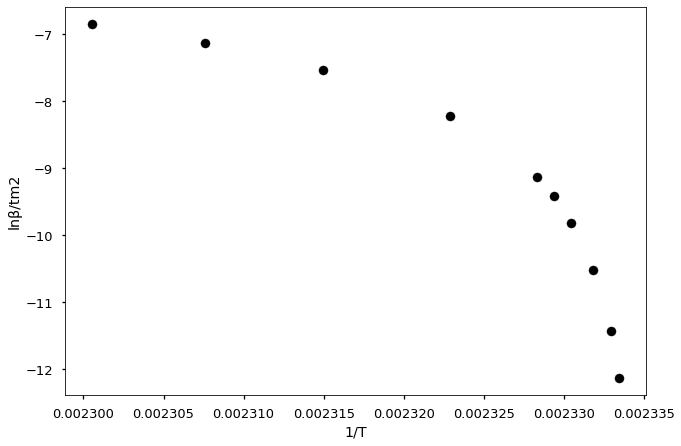

In [15]:
# fig, ax1 = plt.subplots()
# mpl.style.use('seaborn-talk')
# ax1.scatter(df['Heat Rate'], df['Lag Corr. ΔT'], c='black', zorder=1)
# ax1.set_ylabel('Lag Corrected ΔT (K)')
# ax1.set_xlabel('Heating Rate (K/min)')
# ax2 = plt.plot(df['Heat Rate'], df['Heat Rate'] * Rate_Corr.coef[0] + Rate_Corr.coef[1])

fig, ax1 = plt.subplots()
mpl.style.use('seaborn-talk')
ax1.scatter(1/df['Lag Corr. Temp (K)'], df['lnβ/tm2'], c='black', zorder=1)
ax1.set_ylabel('lnβ/tm2')
ax1.set_xlabel('1/T')
# ax2 = plt.plot(df['Heat Rate'], df['Heat Rate'] * Rate_Corr.coef[0] + Rate_Corr.coef[1])